In [108]:
import pydub as pdb
import os 
import tqdm
import librosa
import numpy as np

import skfda
import math 

from scipy.optimize import minimize
from matplotlib import pyplot as plt

In [2]:
our_files = os.listdir("C:/Users/Leonardo/Desktop/UNIVERSITA/MS/I anno/II semestre/SL/FINAL_PROJECT/Nuova cartella/processed-recs")
paper_files = os.listdir("C:/Users/Leonardo/Desktop/UNIVERSITA/MS/I anno/II semestre/SL/FINAL_PROJECT/Nuova cartella/processed-recs-paper")

In [109]:
dic_1 = {file:{'Label':None,
             'Author':None,
             'MFCC':None} for file in our_files}

dic_2 = {file:{'Label':None,
               'MFCC':None} for file in paper_files}

In [124]:
for file in tqdm.tqdm(our_files):
    path = 'C:/Users/Leonardo/Desktop/UNIVERSITA/MS/I anno/II semestre/SL/FINAL_PROJECT/Nuova cartella/processed-recs/' + file
    audio, _ = librosa.load(path, sr=None)  
    dic_1[file]['MFCC'] = librosa.feature.mfcc(y=audio, sr=44100, n_mfcc=12)
    dic_1[file]['Author'] = file.split('_')[2]
    dic_1[file]['Label']  = float(file.split('_')[3][:-4])

for file in tqdm.tqdm(paper_files):
    path = 'C:/Users/Leonardo/Desktop/UNIVERSITA/MS/I anno/II semestre/SL/FINAL_PROJECT/Nuova cartella/processed-recs-paper/' + file
    audio, _ = librosa.load(path, sr=None)
    dic_2[file]['MFCC'] = librosa.feature.mfcc(y=audio, sr=44100, n_mfcc=12,lifter=24)
    dic_2[file]['Label'] = float(file.split('_')[3][:-4])

100%|██████████| 333/333 [00:02<00:00, 146.18it/s]


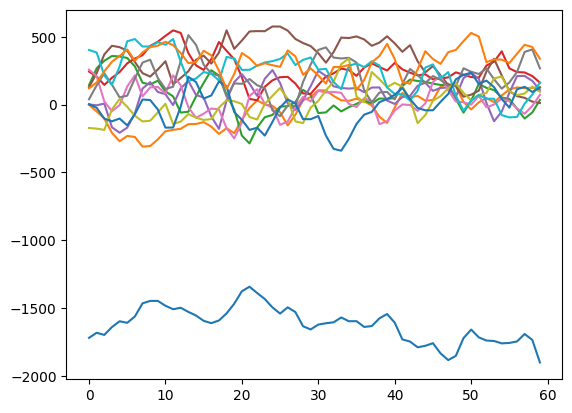

In [125]:
keys = list(dic_2.keys())
plt.plot(dic_2[keys[1]]['MFCC'].transpose())

In [126]:
# Functional tool kit

basis = skfda.representation.basis.Fourier(n_basis=30)

def FDA_generator(array):
    points = np.linspace(0,1,len(array))
    fd_obj = skfda.FDataGrid(data_matrix=[array],
                             grid_points=points)
    return fd_obj

# First transform pipeline: retrieve eGFC from the extracted features

def processing(matrix, basis):
    output = np.zeros((np.shape(matrix)[0],basis.n_basis))
    for i in range(0,np.shape(matrix)[0]):
        fda_obj = FDA_generator(matrix[i,])
        output[i,:] = fda_obj.to_basis(basis).coefficients
    return output

In [127]:
design_tensor = np.zeros((12,31,len(dic_2.values())))

for i in tqdm.tqdm(range(len(dic_2.keys()))):
    key = list(dic_2.keys())[i]
    design_tensor[:,:,i] = processing(dic_2[key]['MFCC'],basis)

y_true = np.array([dic_2[key]['Label'] for key in dic_2.keys()])

100%|██████████| 333/333 [00:02<00:00, 151.70it/s]


In [128]:
design_tensor.shape

(12, 31, 333)

In [129]:
# Non-parametric regression on a vectorial functional space 

def K(t):
    return(0.5*np.exp(-0.5*t**2))

def L2(x1,x2):
    return np.linalg.norm(x1-x2)

def mNorm(X):
    return np.max(np.abs(np.linalg.eigvals(np.matmul(np.transpose(X),X))))

def VF_dist(X1,X2):
    L = np.shape(X1)[0]
    D = np.zeros((L,L))

    for i in range(0,L):
        for k in range(0,L):
            D[i,k] = L2(X1[i,:],X2[i,:])

    return mNorm(D)

def supDist(X1,X2):
    L = np.shape(X1)[0]
    D = np.zeros(L)

    for i in range(0,L):
        D[i] = L2(X1[i,:],X2[i,:])
    
    return np.max(D)

def weightedCompWiseDist(X1,X2,omega):
    L = np.shape(X1)[0]
    D = np.zeros(L)

    for i in range(0,L):
        D[i] = L2(X1[i,:],X2[i,:])
    
    return np.sum(D*omega)
   
def distDist(X1,X2):
    L = np.shape(X1)[0]
    D = np.zeros(L)

    for i in range(0,L):
        D[i] = L2(X1[i,:],X2[i,:])
    
    return np.linalg.norm(D)

def kNN_estimator(x,X,Y,K):
    distances = np.zeros(len(Y))
    for i in range(len(Y)):
        distances[i] = distDist(x,X[:,:,i])
    Y = Y[np.argsort(distances)]
    return np.mean(Y[0:K])/K

def KR_estimator(x,X,Y,omega):
    weights = np.zeros(len(Y))
    for i in range(len(Y)):
        weights[i] = K(weightedCompWiseDist(x,X[:,:,i],omega))
    return np.sum(weights*Y)/np.sum(weights)  

# Validation functions

def LOOCV(X,Y,K):
    err = np.zeros(len(Y))
    for i in range(0,len(Y)):
        x = X[:,:,i]
        y = Y[i]
        _X = X[:,:,[j for j in range(0,len(Y)) if j != i]]
        _Y = Y[[j for j in range(0,len(Y)) if j != i]]
        pred = KR_estimator(x,_X,_Y,K)
        err[i] = (pred-y)**2
        print(y,pred)
    return (np.mean(err))

def LOOCV_fit(X,Y,grid):
    errs = np.zeros(len(grid))
    for p in range(len(grid)):
        errs[p] = LOOCV(X,Y,grid[p])  
    return grid[np.argmin(errs)]

# Minimization problem objective function 

def objective(params):
    omega = params[0:12]
    output = 0
    for i in range(len(y_true)):
        x = design_tensor[:,:,i]
        y = y_true[i]
        _X = design_tensor[:,:,[j for j in range(0,len(y_true)) if j != i]]
        _Y = y_true[[j for j in range(0,len(y_true)) if j != i]]
        pred = KR_estimator(x,_X,_Y,omega)
        output += (pred-y)**2
    return output/len(y_true)

In [130]:
LOOCV(design_tensor,y_true,np.array([ 9.163e-02,  1.316e-01,  9.157e-02,  1.027e-01,  9.452e-02,
                  7.908e-02,  9.513e-02,  1.197e-01,  1.042e-01,  9.303e-02,
                  1.009e-01,  1.041e-01,]))

C:\Users\Leonardo\AppData\Local\Temp\ipykernel_28016\801391253.py:60: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(weights*Y)/np.sum(weights)


27.0 nan
28.0 nan
29.0 nan
30.0 nan
31.0 nan
32.0 nan
33.0 nan
34.0 nan
35.0 nan
37.0 nan
38.0 nan
39.0 nan
40.0 nan
41.0 nan
42.0 nan
43.0 nan
44.0 nan
45.0 nan
46.0 nan
47.0 nan
48.0 nan
49.0 nan
50.0 nan
51.0 nan
52.0 nan
53.0 nan
55.0 nan
56.0 nan
58.0 nan
59.0 nan
61.0 nan
62.0 nan
63.0 nan
65.0 nan
66.0 nan
68.0 nan
70.0 nan
71.0 nan
73.0 nan
77.0 nan
78.0 nan
81.0 nan
83.0 nan
87.0 nan
93.0 nan
6.0 nan
7.0 nan
8.0 nan
9.0 nan
10.0 nan
11.0 nan
12.0 nan
13.0 nan
32.0 nan
33.0 nan
35.0 nan
36.0 nan
37.0 nan
38.0 nan
39.0 nan
40.0 nan
41.0 nan
42.0 nan
44.0 nan
45.0 nan
46.0 nan
47.0 nan
48.0 nan
49.0 nan
50.0 nan
51.0 nan
52.0 nan
53.0 nan
54.0 nan
55.0 nan
56.0 nan
57.0 nan
58.0 nan
59.0 nan
60.0 nan
61.0 nan
62.0 nan
63.0 nan
64.0 nan
65.0 nan
66.0 nan
67.0 nan
68.0 nan
69.0 nan
70.0 nan
71.0 nan
72.0 nan
73.0 nan
74.0 nan
75.0 nan
76.0 nan
77.0 nan
78.0 nan
79.0 nan
80.0 nan
81.0 nan
82.0 nan
83.0 nan
84.0 nan
85.0 nan
87.0 nan
89.0 nan
92.0 nan
95.0 nan
15.0 nan
16.0 nan
17.0 

KeyboardInterrupt: 

In [132]:
minimize(objective, x0=np.array([0.01 for j in range(0,12)]),method = 'Nelder-Mead',options={'maxiter':50})

In [80]:
np.sqrt(310.31786369196465)

17.615841271195784

In [79]:
LOOCV(design_tensor,y_true,np.array([9.163e-02,  1.316e-01,  9.157e-02,  1.027e-01,  9.452e-02,
                  7.908e-02,  9.513e-02,  1.197e-01,  1.042e-01,  9.303e-02,
                  1.009e-01,  1.041e-01,]))

27.0 13.333907935463214
28.0 69.99979354986107
29.0 69.33890895294805
30.0 42.86671542066908
31.0 23.962693314635924
32.0 29.28250749949636
33.0 39.97602367060527
34.0 60.30835857306342
35.0 77.999999970613
37.0 50.02638769770683
38.0 25.5153457969415
39.0 69.73226582065308
40.0 22.154346139262575
41.0 26.963281226955
42.0 37.00000753951952
43.0 77.9999999999647
44.0 69.84697735803854
45.0 54.999978631018614
46.0 65.95862681127896
47.0 14.38617726004581
48.0 50.1674540507838
49.0 68.16733295395947
50.0 59.759887607052086
51.0 48.00023801882378
52.0 76.83176679545063
53.0 69.99913036832197
55.0 69.90475729740476
56.0 55.00568896402913
58.0 65.00801925868628
59.0 58.01317694256493
61.0 55.00000000001078
62.0 62.999999076734944
63.0 62.00000000000001
65.0 69.99979389150168
66.0 77.99999899620278
68.0 77.99999875333828
70.0 77.64179608641666
71.0 58.00000000000016
73.0 86.39707026732151
77.0 80.99999922198731
78.0 69.56351168619695
81.0 46.25274609761482
83.0 77.8271326656627
87.0 74.14716

310.31786369196465

In [84]:
# Tensorizing the operations

def vec_L2(X1,X2):
    return np.linalg.norm(np.sum([X1,-X2],axis=0),axis=1)

def vec_weightedCompWiseDist(X1,X2,omega):
    return vec_L2(X1,X2)*omega

def vec_LOOCV(X,Y,h,omega):
    mask = np.array([[j for j in range(0,len(Y)) if j != i] 
                        for i in range(0,len(Y))])
    
    LOO_design_tensor = X[:,:,mask]
    LOO_y_true = Y[mask]

    dist_tens = vec_L2(np.repeat(X[:,:,:,np.newaxis], 332, 3),LOO_design_tensor)*omega[:,:,np.newaxis]/h
    weights = K(dist_tens)

In [139]:
mask = np.array([[j for j in range(0,len(y_true)) if j != i] for i in range(0,len(y_true))])

LOO_design_tensor = design_tensor[:,:,mask]
LOO_y_true = y_true[mask]